TypeError: FancyBboxPatch.__init__() got multiple values for argument 'width'

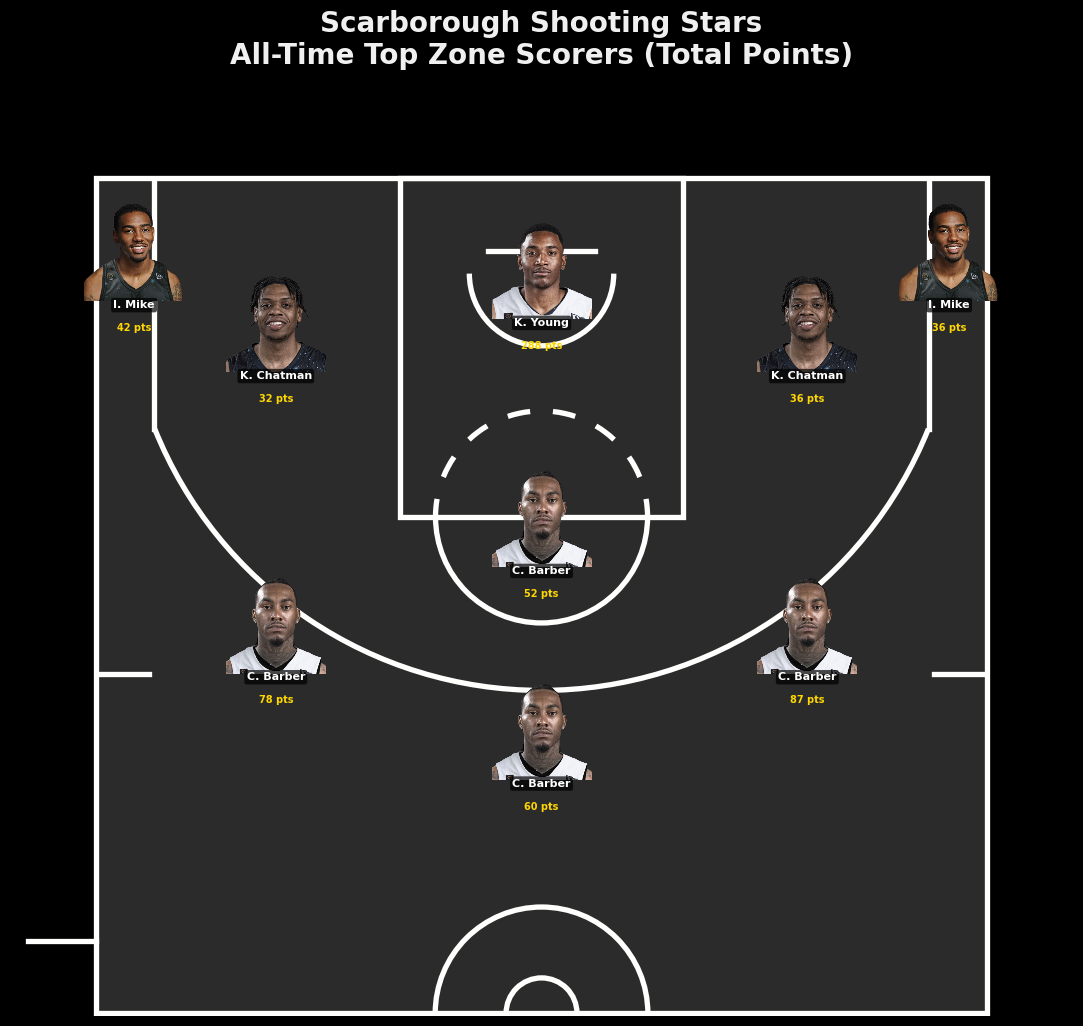

In [4]:
import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from mplbasketball import Court


def create_zone_visualizations(team_name):
    """
    Create three visualizations for a team's zone scorers:
    1. Top scorers by total points
    2. Top scorers by points per game
    3. Top scorers by field goal percentage
    """
    # === Configuration ===
    ORIENTATION = "vu"
    ORIGIN = "bottom-left"
    COURT_COLOR = "#2B2B2B"
    LINE_COLOR = "#FFFFFE"
    TITLE_COLOR = "#F0F0F0"  # Light color for better contrast
    TITLE_BG_COLOR = "#0A2A66"  # Dark blue background
    BASE_IMG_URL = f"./img/{team_name.split('_')[0]}/{{player_name}}.png"

    # Clean name for display
    display_name = team_name.replace("_", " ")

    # Load team data
    file_path = f"team_zone_top_scorers/{team_name}_zone_top_scorers.csv"
    df = pd.read_csv(file_path)

    # Calculate points per game (estimated from attempts)
    # Assuming average of 10 attempts per game
    ATTEMPTS_PER_GAME = 10
    df["estimated_games"] = df["total_attempts"] / ATTEMPTS_PER_GAME
    df["points_per_game"] = df["total_points"] / df["estimated_games"]

    # Define zone coordinates on the court
    zone_coordinates = {
        "left_corner": (-48, 90),
        "left_short_corner": (-40, 86),
        "left_wing_three": (-40, 69),
        "restricted_area": (-25, 89),
        "right_corner": (-2, 90),
        "right_short_corner": (-10, 86),
        "right_wing_three": (-10, 69),
        "top_key_midrange": (-25, 75),
        "top_key_three": (-25, 63),
    }

    # === Helper functions ===
    def get_player_image(player_name):
        """Load and resize a player's image"""
        player_img_path = BASE_IMG_URL.format(player_name=player_name)
        try:
            img = mpimg.imread(player_img_path)
            return OffsetImage(img, zoom=0.18)  # Slightly smaller
        except FileNotFoundError:
            print(f"Image not found: {player_img_path}")
            return None

    def setup_court():
        """Create and configure the court figure"""
        court = Court(court_type="nba", origin=ORIGIN, units="ft")
        fig, ax = plt.subplots(figsize=(18, 12), facecolor="black")

        # Draw the court
        court.draw(
            ax,
            court_color=COURT_COLOR,
            line_color=LINE_COLOR,
            line_width=0.3,
            orientation=ORIENTATION,
        )
        return fig, ax

    def style_title(ax, title_text):
        """Apply consistent styling to the title"""
        title = ax.set_title(
            title_text,
            fontsize=20,
            color=TITLE_COLOR,
            fontweight="bold",
            pad=20,  # More space above title
        )

        # Add a background bar for the title
        fig = plt.gcf()
        fig.text(
            0.5,
            0.96,  # Position at top center
            " ",  # Empty text, just for background
            transform=ax.transAxes,
            ha="center",
            fontsize=24,
            bbox=dict(
                facecolor=TITLE_BG_COLOR,
                edgecolor="none",
                boxstyle="round,pad=0.6",
                alpha=0.9,
                width=fig.get_figwidth() * 0.8,
            ),
        )

        # Place title text above the background
        return title

    # === Create visualizations ===
    # 1. Total Points Visualization
    def create_total_points_viz():
        top_scorers = (
            df.sort_values("total_points", ascending=False)
            .groupby("zone")
            .first()
            .reset_index()
        )
        fig, ax = setup_court()

        for _, row in top_scorers.iterrows():
            zone, player = row["zone"], row["player"]
            points = int(row["total_points"])

            if zone not in zone_coordinates:
                continue

            x, y = zone_coordinates[zone]

            # Add player image
            player_img = get_player_image(player)
            if player_img:
                ab = AnnotationBbox(player_img, (x, y), frameon=False)
                ax.add_artist(ab)

                # Add player name and points with smaller text
                ax.text(
                    x,
                    y - 3.2,
                    f"{player}",
                    fontsize=8,
                    color="white",
                    ha="center",
                    fontweight="bold",
                    bbox=dict(
                        facecolor="black",
                        alpha=0.7,
                        edgecolor="none",
                        boxstyle="round,pad=0.2",
                    ),
                )

                ax.text(
                    x,
                    y - 4.5,
                    f"{points} pts",
                    fontsize=7,
                    color="#FFD700",  # Gold color for points
                    ha="center",
                    fontweight="bold",
                )

        style_title(ax, f"{display_name}\nAll-Time Top Zone Scorers (Total Points)")

        # Create output directory if it doesn't exist
        os.makedirs("visualizations", exist_ok=True)
        plt.savefig(
            f"visualizations/{team_name}_top_scorers_total.png",
            dpi=300,
            bbox_inches="tight",
            facecolor="black",
        )
        plt.close()

    # 2. Points Per Game Visualization
    def create_ppg_viz():
        top_ppg_scorers = (
            df.sort_values("points_per_game", ascending=False)
            .groupby("zone")
            .first()
            .reset_index()
        )
        fig, ax = setup_court()

        for _, row in top_ppg_scorers.iterrows():
            zone, player = row["zone"], row["player"]
            ppg = row["points_per_game"]

            if zone not in zone_coordinates:
                continue

            x, y = zone_coordinates[zone]

            # Add player image
            player_img = get_player_image(player)
            if player_img:
                ab = AnnotationBbox(player_img, (x, y), frameon=False)
                ax.add_artist(ab)

                # Add player name and ppg with smaller text
                ax.text(
                    x,
                    y - 3.2,
                    f"{player}",
                    fontsize=8,
                    color="white",
                    ha="center",
                    fontweight="bold",
                    bbox=dict(
                        facecolor="black",
                        alpha=0.7,
                        edgecolor="none",
                        boxstyle="round,pad=0.2",
                    ),
                )

                ax.text(
                    x,
                    y - 4.5,
                    f"{ppg:.1f} PPG",
                    fontsize=7,
                    color="#FF9500",  # Orange for PPG
                    ha="center",
                    fontweight="bold",
                )

        style_title(ax, f"{display_name}\nAll-Time Top Zone Scorers (Points Per Game)")
        plt.savefig(
            f"visualizations/{team_name}_top_scorers_ppg.png",
            dpi=300,
            bbox_inches="tight",
            facecolor="black",
        )
        plt.close()

    # 3. Field Goal Percentage Visualization
    def create_fg_pct_viz():
        # Only include players with minimum attempts
        qualified_df = df[df["total_attempts"] >= 10]
        top_fg_scorers = (
            qualified_df.sort_values("fg_percentage", ascending=False)
            .groupby("zone")
            .first()
            .reset_index()
        )
        fig, ax = setup_court()

        for _, row in top_fg_scorers.iterrows():
            zone, player = row["zone"], row["player"]
            fg_pct = row["fg_percentage"]
            attempts = int(row["total_attempts"])

            if zone not in zone_coordinates:
                continue

            x, y = zone_coordinates[zone]

            # Add player image
            player_img = get_player_image(player)
            if player_img:
                ab = AnnotationBbox(player_img, (x, y), frameon=False)
                ax.add_artist(ab)

                # Add player name and FG% with smaller text
                ax.text(
                    x,
                    y - 3.2,
                    f"{player}",
                    fontsize=8,
                    color="white",
                    ha="center",
                    fontweight="bold",
                    bbox=dict(
                        facecolor="black",
                        alpha=0.7,
                        edgecolor="none",
                        boxstyle="round,pad=0.2",
                    ),
                )

                ax.text(
                    x,
                    y - 4.5,
                    f"{fg_pct * 100:.1f}% FG ({attempts} att)",
                    fontsize=7,
                    color="#00FF00",  # Green for efficiency
                    ha="center",
                    fontweight="bold",
                )

        style_title(ax, f"{display_name}\nAll-Time Top Zone Scorers (Field Goal %)")
        plt.savefig(
            f"visualizations/{team_name}_top_scorers_fg_pct.png",
            dpi=300,
            bbox_inches="tight",
            facecolor="black",
        )
        plt.close()

    # Generate all three visualizations
    create_total_points_viz()
    create_ppg_viz()
    create_fg_pct_viz()

    print(
        f"Created three visualizations for {display_name} in the 'visualizations' folder"
    )


# Example usage
create_zone_visualizations("Scarborough_Shooting_Stars")
